# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import os.path
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import metrics 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.svm import SVC

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Data Exploration and Analysis

First we take a look at portfolio data

In [2]:
# check the portfolio data structure
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
# check dataset type
portfolio.dtypes

channels      object
difficulty     int64
duration       int64
id            object
offer_type    object
reward         int64
dtype: object

Second we can perform some analysis on profile data

In [4]:
# check profile data structure
profile.head(5)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
# check profile data type
profile.dtypes

age                   int64
became_member_on      int64
gender               object
id                   object
income              float64
dtype: object

In [6]:
# check profile data
profile.shape

(17000, 5)

In [7]:
# check the NaN value
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [8]:
# take a look at NaN value
profile[(profile['gender'].isnull()) | (profile['income'].isnull())].head(10)

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN
6,118,20170925,None,8ec6ce2a7e7949b1bf142def7d0e0586,NaN
7,118,20171002,None,68617ca6246f4fbc85e91a2a49552598,NaN
9,118,20161122,None,8974fc5686fe429db53ddde067b88302,NaN
10,118,20170824,None,c4863c7985cf408faee930f111475da3,NaN
11,118,20150919,None,148adfcaa27d485b82f323aaaad036bd,NaN
17,118,20170801,None,744d603ef08c4f33af5a61c8c7628d1c,NaN
23,118,20170907,None,2b826eba31074a059d63b0ae8f50b7d5,NaN


In [9]:
# it looks like that the NaN values are pairs with gender and income, in addition the age column looks weired as well
# as there are low percentage of the NaN row, so we simply delete these rows
profile = profile[(profile['gender'].notnull()) & (profile['income'].notnull())]
profile.shape

(14825, 5)

In [10]:
# the column 'became_member_on' makes sense to extract the number of days since they are member
# so we can create a new column named 'since_member_day'
profile['since_member_day'] = pd.to_datetime(20220613, format='%Y%m%d') - pd.to_datetime(profile['became_member_on'], format='%Y%m%d')
profile['since_member_day'] = profile['since_member_day'].dt.days

In [11]:
# check the profile data
profile.describe()

,age,became_member_on,income,since_member_day
count,14825.000000,1.482500e+04,14825.000000,14825.000000
mean,54.393524,2.016689e+07,65404.991568,1940.478988
std,17.383705,1.188565e+04,21598.299410,419.205158
min,18.000000,2.013073e+07,30000.000000,1418.000000
25%,42.000000,2.016052e+07,49000.000000,1626.000000
50%,55.000000,2.017080e+07,64000.000000,1776.000000
75%,66.000000,2.017123e+07,80000.000000,2215.000000
max,101.000000,2.018073e+07,120000.000000,3241.000000


In [12]:
# it makes sense that in reality everyday has new members, so we pick that minimum 'since_member_day' as a benchmark,
# which means we can minus all rows in this column by 1418, and also drop the member date to further plot
profile['since_member_day'] = profile['since_member_day'] - 1418
profile_sns = profile.drop(columns = ['became_member_on'])

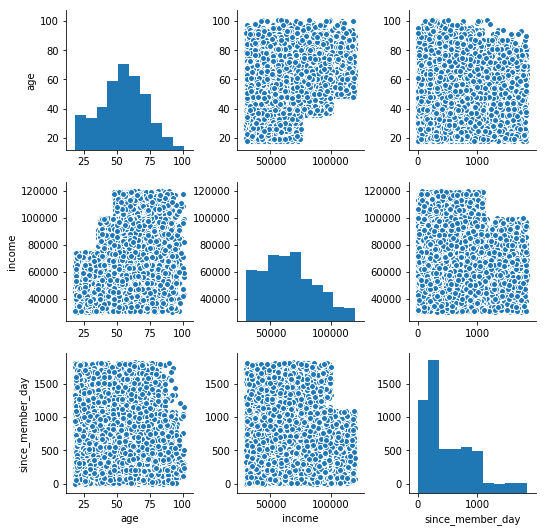

In [13]:
# visualize the profile data
sns.pairplot(profile_sns)

The age, income and since_member_day seem to be numeric features for further analysis. Next we explore and preprocess the transcript data

In [14]:
# check transcript data structure
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [15]:
# check transcript data type
transcript.dtypes

event     object
person    object
time       int64
value     object
dtype: object

# Data Preprocessing

For transcript data, we need to do a lot of data cleaning to extract the information

In [16]:
# restructure the value column, combine the offer_id column and drop columns not necessary before save to folder
if os.path.exists('data/transcript_preprocessed.json') == False:
    transcript_preprocessed = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis = 1)
    transcript_preprocessed['offer_id'] = np.where(transcript_preprocessed['offer_id'].isnull(), transcript_preprocessed['offer id'], transcript_preprocessed['offer_id'])
    transcript_preprocessed.drop(['value', 'offer id'], axis = 1, inplace = True)
    transcript_preprocessed.to_json('data/transcript_preprocessed.json', orient='records', lines=True)

# read processed data if already exists
if os.path.exists('data/transcript_preprocessed.json') == True:
    transcript_preprocessed = pd.read_json('data/transcript_preprocessed.json', orient='records', lines=True)

In [17]:
# check processed transcript data
transcript_preprocessed.head()

,amount,event,offer_id,person,reward,time
0,NaN,offer received,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,NaN,0
1,NaN,offer received,0b1e1539f2cc45b7b9fa7c272da2e1d7,a03223e636434f42ac4c3df47e8bac43,NaN,0
2,NaN,offer received,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,NaN,0
3,NaN,offer received,fafdcd668e3743c1bb461111dcafc2a4,8ec6ce2a7e7949b1bf142def7d0e0586,NaN,0
4,NaN,offer received,4d5c57ea9a6940dd891ad53e9dbe8da0,68617ca6246f4fbc85e91a2a49552598,NaN,0


As per the time customers receive offer, there would be below senarios on how they respond:

Senario 1. For actions what we desired, which offer can generate extra sales:
   - offer received > offer viewed > transaction > *

Senario 2. For actions that customers don't take action to offers that they're already aware of
   - offer received > offer viewed

Senario 3. For customers who still pay though they're not aware of offers
   - offer received > transaction > *

Senario 4. For customers who received offers but don't take any actions
   - offer received
   
So in order to map transactions to offer, we can:
1. For discount and BOGO offers, we can mark 'offer completed'/'transaction' that taken place at the same time as a pair to fill offer id.
2. For informational offers, we can mark the most recent(next) 'transaction' within validity period to the offer id of 'offer received'.

In [18]:
# for discount and BOGO offers, we can select all 'offer completed' & 'transaction' events, mapping offer id of offer completed to transaction which taken place at the same time
transcript_offer_id = transcript_preprocessed
offer_id_disbogo = transcript_offer_id[(transcript_offer_id['event'] == 'offer completed') | (transcript_offer_id['event'] == 'transaction')].sort_values(by = ['person', 'time'])['offer_id'].fillna(method = 'bfill', limit = 1)

In [19]:
# replace the mapped discount and BOGO offer_id to transcript_processed
transcript_offer_id.loc[offer_id_disbogo.index, 'offer_id'] = offer_id_disbogo

In [20]:
# select all 'offer received' and 'transaction' events apart from discount and BOGO entries
offer_id_info = transcript_offer_id[((transcript_offer_id['event'] == 'offer received') & (transcript_offer_id['offer_id'].isin(portfolio[portfolio['offer_type'] == 'informational']['id'])))
                                               | ((transcript_offer_id['event'] == 'transaction') & (transcript_offer_id['offer_id'].isnull()))].sort_values(by = ['person', 'time'])

# get a subset of informational offer received by time
offer_id_info_viewed = transcript_offer_id[((transcript_offer_id['event'] == 'offer viewed') & (transcript_offer_id['offer_id'].isin(portfolio[portfolio['offer_type'] == 'informational']['id'])))][['offer_id', 'person', 'time']]

In [21]:
# iterate rows in informational_transcript, fill the the offer id for the next transaction after offer viewed within validity period
if os.path.exists('data/transcript_offer_id.json') == False:
    
    for index, row in offer_id_info.iterrows():
        
        # check there are both offer received and offer viewed rows in data
        if (row['event'] == 'offer received') & (row['offer_id'] in (offer_id_info_viewed[offer_id_info_viewed['person'] == row['person']]['offer_id'].values)):
            receive_time = row['time']
            view_time = offer_id_info_viewed[(offer_id_info_viewed['offer_id'] == row['offer_id']) & (offer_id_info_viewed['person'] == row['person'])]['time'].values[0]
            
            # check next 10 rows after offer received
            for i in range(10):
                
                # get next index to find next transaction
                next_transaction_ordinal_ind = offer_id_info.index.get_loc(index) + i
                if offer_id_info.iloc[next_transaction_ordinal_ind, 1] == 'transaction':
                    transaction_time = offer_id_info.iloc[next_transaction_ordinal_ind, -1]
            
                    # if transaction is within the validity period after offer received, mark the transaction with that offer id
                    if (portfolio[portfolio['id'] == row['offer_id']]['duration'].values[0] * 24 > (transaction_time - receive_time)) & ((view_time >= receive_time) & (view_time <= transaction_time)):
                        offer_id_info.iloc[next_transaction_ordinal_ind, -4] = row['offer_id']
                        
                    # stop loop if we find a transaction
                    break

                        
    # replace the mapped informational offer_id to transcript_processed
    transcript_offer_id.loc[offer_id_info.index, 'offer_id'] = offer_id_info['offer_id']

    # save data
    transcript_offer_id.to_json('data/transcript_offer_id.json', orient='records', lines=True)

# read processed data if already exists
if os.path.exists('data/transcript_offer_id.json') == True:
    transcript_offer_id = pd.read_json('data/transcript_offer_id.json', orient='records', lines=True)

We can simply define above senarios as:

1. For Senario 1 it's Positive, which means we can send offers in these cases to get more sales
2. For Senario 2 it's Negative, which means the offer in these cases make no sense to get sales
3. For Senario 3&4 it's Neutral, which means we need to further analysis how we deal with these offers to customers

As we are curious about how customer will respond to each type of offer (discount/BOGO/informational) - whether they will give positive/negative/neutral feedback on each type of offer. So if there will be multiple same offers sent to a customer, as long as there is a positive feedback in these same offers, we take it as a positive feedback.

In [22]:
# build a function to get customer feedbacks
def get_results(df):
    
    # Build customer & offer id dataframe from transcript data
    customer_offer = df[df['offer_id'].notnull()][['offer_id', 'person']].drop_duplicates()
    
    # get subset of transcript data
    transaction_df = df[(df['event'] == 'transaction') & (df['offer_id'].notnull())][['offer_id', 'person']].drop_duplicates()
    viewed_df = df[(df['event'] == 'offer viewed')][['offer_id', 'person']].drop_duplicates()
    
    # get intersection of transaction and viewed entries as positive feedback
    positives = transaction_df.merge(viewed_df, how = 'inner', on = ['offer_id', 'person'])
    positives['results'] = 'positive'
    
    # get rows only in offer viewed that not in transaction as negative feedback
    transaction_df['label'] = 'X'
    non_transaction_df = customer_offer.merge(transaction_df, how = 'left', on = ['offer_id', 'person'])
    non_transaction_df = non_transaction_df[non_transaction_df['label'].isnull()]
    non_transaction_df.drop(columns = ['label'], inplace = True)
    negatives = non_transaction_df.merge(viewed_df, how = 'inner', on = ['offer_id', 'person'])
    negatives['results'] = 'negative'
    
    # merge positives and negatives feedback together
    customer_offer_pos = customer_offer.merge(positives, how = 'left', on = ['offer_id', 'person'])
    customer_offer_pos_neg = customer_offer_pos.merge(negatives, how = 'left', on = ['offer_id', 'person'])
    customer_offer_pos_neg['results_x'] = np.where(customer_offer_pos_neg['results_x'].isnull(), customer_offer_pos_neg['results_y'], customer_offer_pos_neg['results_x'])
    
    # set rows that neither not positive nor not negative with offer received entires as neutral feedback
    customer_offer_pos_neg['results_x'] = customer_offer_pos_neg['results_x'].fillna('neutral')
    customer_offer_results = customer_offer_pos_neg.drop(columns = ['results_y'])
    customer_offer_results.rename(columns = {'results_x' : 'results'}, inplace = True)
                
    return customer_offer_results

In [23]:
customer_offer_results = get_results(transcript_offer_id)

In [24]:
# merge profile data to the customer_offer_results
profile.rename(columns = {'id' : 'person'}, inplace = True)
processed_data = customer_offer_results.merge(profile, how = 'right', on = ['person'])

In [25]:
# drop null values if any in offer_id or results
processed_data = processed_data[processed_data['offer_id'].notnull()]

In [26]:
# merge portfolio data to processed_data
portfolio.rename(columns = {'id' : 'offer_id'}, inplace = True)
processed_data = processed_data.merge(portfolio, how = 'left', on = ['offer_id'])

In [27]:
# its also interesting to find how many transactions (how much momey as well) customer make without an offer
no_offer_transaction = transcript_offer_id[(transcript_offer_id['event'] == 'transaction') & (transcript_offer_id['offer_id'].isnull())]
no_offer_transaction_number = no_offer_transaction.groupby(by = ['person']).count()['event']
no_offer_transaction_amount = no_offer_transaction.groupby(by = ['person']).sum()['amount']
no_offer_transaction_data = pd.concat([no_offer_transaction_number, no_offer_transaction_amount], axis = 1).reset_index()
no_offer_transaction_data.rename(columns = {'event' : 'no_offer_num', 'amount' : 'no_offer_amount'}, inplace = True)

In [28]:
# merge the number and amount of no offer transactions to processed data, for NaN values simply set to zero.
processed_data = processed_data.merge(no_offer_transaction_data, how = 'left', on = ['person'])
processed_data = processed_data.fillna(0)

Do some further data exporation and analysis on processed_data, to see if we can find more interesting information

In [29]:
# check the processed data
processed_data.head(10)

,offer_id,person,results,age,became_member_on,gender,income,since_member_day,channels,difficulty,duration,offer_type,reward,no_offer_num,no_offer_amount
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,78afa995795e4d85b5d9ceeca43f5fef,positive,75,20170509,F,100000.0,443,"[web, email, mobile]",5,7,bogo,5,4.0,97.99
1,5a8bc65990b245e5a138643cd4eb9837,78afa995795e4d85b5d9ceeca43f5fef,positive,75,20170509,F,100000.0,443,"[email, mobile, social]",0,3,informational,0,4.0,97.99
2,ae264e3637204a6fb9bb56bc8210ddfd,78afa995795e4d85b5d9ceeca43f5fef,positive,75,20170509,F,100000.0,443,"[email, mobile, social]",10,7,bogo,10,4.0,97.99
3,f19421c1d4aa40978ebb69ca19b0e20d,78afa995795e4d85b5d9ceeca43f5fef,negative,75,20170509,F,100000.0,443,"[web, email, mobile, social]",5,5,bogo,5,4.0,97.99
4,2906b810c7d4411798c6938adc9daaa5,e2127556f4f64592b11af22de27a7932,negative,68,20180426,M,70000.0,91,"[web, email, mobile]",10,7,discount,2,2.0,39.31
5,3f207df678b143eea3cee63160fa8bed,e2127556f4f64592b11af22de27a7932,neutral,68,20180426,M,70000.0,91,"[web, email, mobile]",0,4,informational,0,2.0,39.31
6,9b98b8c7a33c4b65b9aebfe6a799e6d9,e2127556f4f64592b11af22de27a7932,positive,68,20180426,M,70000.0,91,"[web, email, mobile]",5,7,bogo,5,2.0,39.31
7,fafdcd668e3743c1bb461111dcafc2a4,e2127556f4f64592b11af22de27a7932,negative,68,20180426,M,70000.0,91,"[web, email, mobile, social]",10,10,discount,2,2.0,39.31
8,f19421c1d4aa40978ebb69ca19b0e20d,389bc3fa690240e798340f5a15918d5c,positive,65,20180209,M,53000.0,167,"[web, email, mobile, social]",5,5,bogo,5,0.0,0.00
9,9b98b8c7a33c4b65b9aebfe6a799e6d9,389bc3fa690240e798340f5a15918d5c,negative,65,20180209,M,53000.0,167,"[web, email, mobile]",5,7,bogo,5,0.0,0.00


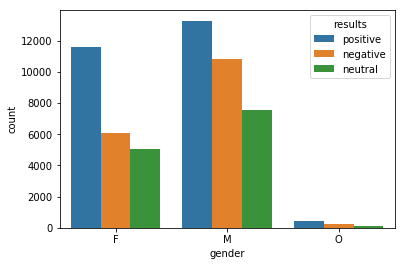

In [30]:
# check customer feedback on gender
sns.countplot(x = 'gender', hue = 'results', data = processed_data)

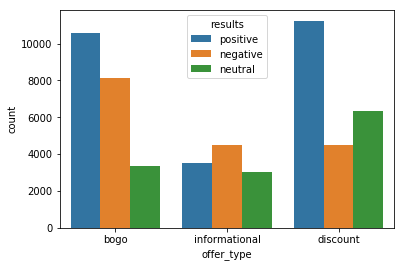

In [31]:
# check customer feedback on offer_type
sns.countplot(x = 'offer_type', hue = 'results', data = processed_data)

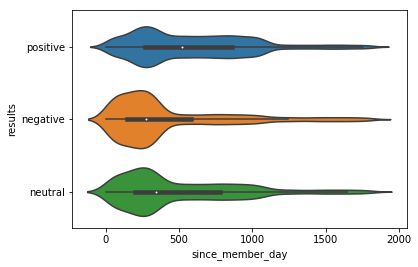

In [32]:
# check customer feedback on customer tenure
sns.violinplot(x = 'since_member_day', y = 'results', data = processed_data)

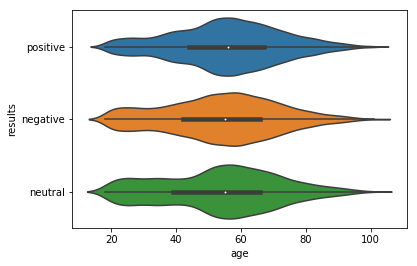

In [33]:
# check customer feedback on age
sns.violinplot(x = 'age', y = 'results', data = processed_data)

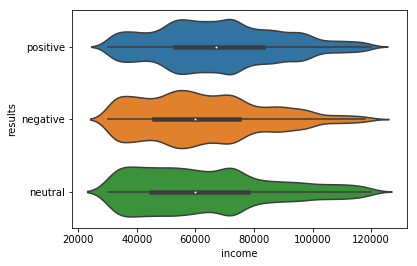

In [34]:
# check customer feedback on income
sns.violinplot(x = 'income', y = 'results', data = processed_data)

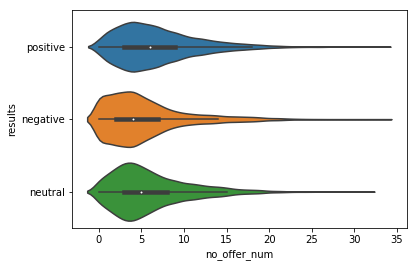

In [35]:
# check customer feedback on no_offer_num
sns.violinplot(x = 'no_offer_num', y = 'results', data = processed_data)

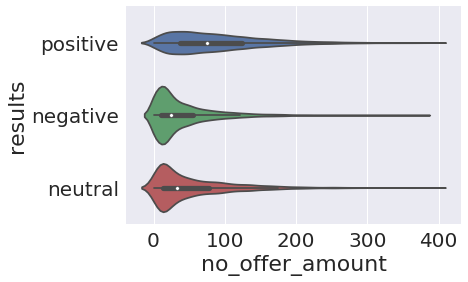

In [56]:
# check customer feedback on no_offer_amount
sns.violinplot(x = 'no_offer_amount', y = 'results', data = processed_data[processed_data['no_offer_amount'] < 400])

In [37]:
# find all entries as per different feedback respectively
positives = processed_data[processed_data['results'] == 'positive']
negatives = processed_data[processed_data['results'] == 'negative']
neutrals = processed_data[processed_data['results'] == 'neutral']

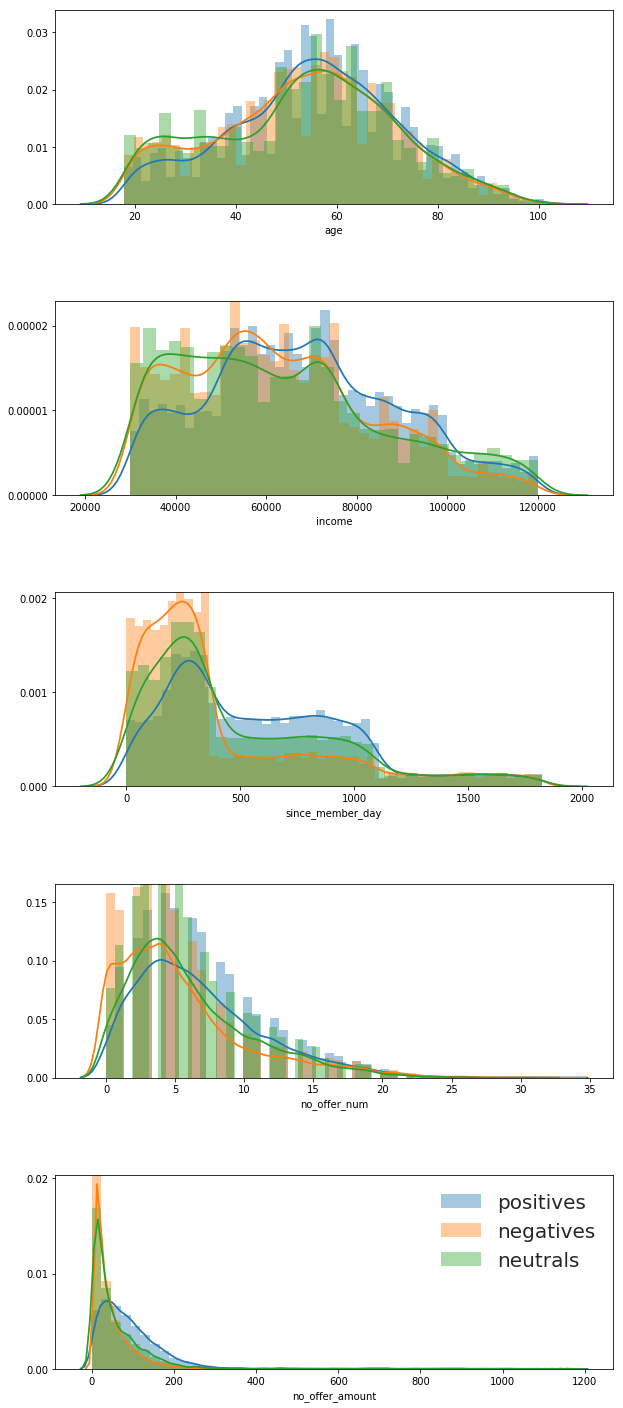

In [38]:
# find distributions of each results category
to_plot_feature = ['age', 'income', 'since_member_day', 'no_offer_num', 'no_offer_amount']
fig, ax = plt.subplots(len(to_plot_feature), 1, figsize = (10, 25))
sns.set(font_scale = 2)
plt.subplots_adjust(hspace = 0.5)
ax = ax.flatten()

i = 0
for feature in to_plot_feature:
    sns.distplot(positives[feature], ax = ax[i], label = 'positives')
    sns.distplot(negatives[feature], ax = ax[i], label = 'negatives')
    sns.distplot(neutrals[feature], ax = ax[i], label = 'neutrals')
    i += 1
    plt.legend(fontsize = 20)

In [39]:
# one-hot encoding for channels column
channels_encoded = MultiLabelBinarizer().fit_transform(processed_data['channels'])
df_channels_encoded = pd.DataFrame(channels_encoded, columns=['email', 'mobile', 'social', 'web'])

In [40]:
# encoding the gender and offer_type column
gender_encoded = pd.get_dummies(processed_data['gender'])
offer_type_encoded = pd.get_dummies(processed_data['offer_type'])

In [41]:
# Concating the portfolio dataframe with the df_portofolio_encoded
processed_data_encoded = pd.concat([processed_data, df_channels_encoded, gender_encoded, offer_type_encoded], axis = 1, sort = True)

In [42]:
# set predict values to integer and drop columns not relevant
processed_data_encoded.loc[processed_data_encoded['results'] == 'positive', 'results'] = 0
processed_data_encoded.loc[processed_data_encoded['results'] == 'negative', 'results'] = 1
processed_data_encoded.loc[processed_data_encoded['results'] == 'neutral', 'results'] = 2
data = processed_data_encoded.drop(columns = ['offer_id', 'person', 'became_member_on', 'gender', 'channels', 'offer_type'])

In [43]:
# check the data to be fed into model
data.head(10)

,results,age,income,since_member_day,difficulty,duration,reward,no_offer_num,no_offer_amount,email,mobile,social,web,F,M,O,bogo,discount,informational
0,0,75,100000.0,443,5,7,5,4.0,97.99,1,1,0,1,1,0,0,1,0,0
1,0,75,100000.0,443,0,3,0,4.0,97.99,1,1,1,0,1,0,0,0,0,1
2,0,75,100000.0,443,10,7,10,4.0,97.99,1,1,1,0,1,0,0,1,0,0
3,1,75,100000.0,443,5,5,5,4.0,97.99,1,1,1,1,1,0,0,1,0,0
4,1,68,70000.0,91,10,7,2,2.0,39.31,1,1,0,1,0,1,0,0,1,0
5,2,68,70000.0,91,0,4,0,2.0,39.31,1,1,0,1,0,1,0,0,0,1
6,0,68,70000.0,91,5,7,5,2.0,39.31,1,1,0,1,0,1,0,1,0,0
7,1,68,70000.0,91,10,10,2,2.0,39.31,1,1,1,1,0,1,0,0,1,0
8,0,65,53000.0,167,5,5,5,0.0,0.00,1,1,1,1,0,1,0,1,0,0
9,1,65,53000.0,167,5,7,5,0.0,0.00,1,1,0,1,0,1,0,1,0,0


# Model Implemetation

The first step in model implemetation is to create a baseline for the prediction. Here I would like to use random forest algorithm.

In [44]:
# set features and labels of the data
X = data.drop(columns = ['results'])
y = data.results

In [45]:
# split the test and training set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

In [46]:
# creating a LogisticRegression classifier as benchmark
lr_clf = LogisticRegression() 
 
# Training the model on the training dataset
# fit function is used to train the model using the training sets as parameters
lr_clf.fit(X_train, y_train)
 
# performing predictions on the test dataset
y_pred = lr_clf.predict(X_test)
 
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))
print('Classification Report:\n', metrics.classification_report(y_test, y_pred, target_names = ['positive', 'negative', 'neutral']))

ACCURACY OF THE MODEL:  0.5797856936
Classification Report:
              precision    recall  f1-score   support

   positive       0.61      0.82      0.70      6410
   negative       0.48      0.44      0.46      4233
    neutral       0.64      0.29      0.40      3169

avg / total       0.58      0.58      0.56     13812



# Refinement and Evaluation

In [47]:
# Try standardization and normalization of dataset

def build_model(algo):
    
    # using pipeline to build work flow
    pipeline = Pipeline([
        ('std',  StandardScaler()),
        ('norm', MinMaxScaler()),
        ('algo_clf', algo)
    ])
    
    return pipeline

In [48]:
# Build a function for training, prediction and further evaluation

def train_predict_eval(X, y, algo):
    
    # set training, testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    model = build_model(algo)
    
    # fit the model
    model.fit(X_train, y_train)
    
    # predict test data
    y_pred = model.predict(X_test)
    
    print('----------------------------------------------------------------')
    print('Accuracy of {}: '.format(algo) , metrics.accuracy_score(y_test, y_pred))
    print('Classification Report of {}:\n'.format(algo), metrics.classification_report(y_test, y_pred, target_names = ['positive', 'negative', 'neutral']))

In [50]:
# first lets pick an algorithm that performs best over the data
algo_to_pick = [LogisticRegression(), KNeighborsClassifier(), SVC(), RandomForestClassifier()]

for algo in algo_to_pick:
    train_predict_eval(X, y, algo)

----------------------------------------------------------------
Accuracy of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):  0.613958876339
Classification Report of LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False):
              precision    recall  f1-score   support

   positive       0.66      0.69      0.67      6320
   negative       0.62      0.43      0.50      4263
    neutral       0.55      0.72      0.62      3229

avg / total       0.62      0.61      0.61     13812

----------------------------------------------------------------
Accuracy of KNei

In [51]:
# As RandomForestClassifier performs the best, so it is picked to fine tune the hyperparameters via Grid Search
def tune_model():
    
    # using pipeline to build workflow
    pipeline = Pipeline([
        ('std',  StandardScaler()),
        ('norm', MinMaxScaler()),
        ('clf', RandomForestClassifier())
    ])
    
    # set the hyper-parameter grid for further training and prediction
    parameters = {
        'clf__n_estimators': [100, 200],
        'clf__min_samples_split': [3, 4, 5]
    }
    
    cv = GridSearchCV(pipeline, param_grid = parameters, verbose = 10)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
    
    cv.fit(X_train, y_train)
    y_pred = cv.predict(X_test)
    
    print('----------------------------------------------------------------')
    print('Accuracy of RandomForest with {}: '.format(cv.best_params_), metrics.accuracy_score(y_test, y_pred))
    print('Classification Report of RandomForest:\n', metrics.classification_report(y_test, y_pred, target_names = ['positive', 'negative', 'neutral']))

In [52]:
tune_model()

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] clf__min_samples_split=3, clf__n_estimators=100 .................
[CV]  clf__min_samples_split=3, clf__n_estimators=100, score=0.6674630755864466, total=   4.3s
[CV] clf__min_samples_split=3, clf__n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.9s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=100, score=0.6692006950477846, total=   4.4s
[CV] clf__min_samples_split=3, clf__n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    9.9s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=100, score=0.6694424330195511, total=   4.4s
[CV] clf__min_samples_split=3, clf__n_estimators=200 .................


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   15.0s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=200, score=0.6681870836953374, total=   8.6s
[CV] clf__min_samples_split=3, clf__n_estimators=200 .................


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.9s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=200, score=0.6678974804517811, total=   8.6s
[CV] clf__min_samples_split=3, clf__n_estimators=200 .................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   34.7s remaining:    0.0s


[CV]  clf__min_samples_split=3, clf__n_estimators=200, score=0.6708906589427951, total=   8.6s
[CV] clf__min_samples_split=4, clf__n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   44.7s remaining:    0.0s


[CV]  clf__min_samples_split=4, clf__n_estimators=100, score=0.6703591080220098, total=   4.2s
[CV] clf__min_samples_split=4, clf__n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   49.5s remaining:    0.0s


[CV]  clf__min_samples_split=4, clf__n_estimators=100, score=0.6694902982913409, total=   4.3s
[CV] clf__min_samples_split=4, clf__n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   54.4s remaining:    0.0s


[CV]  clf__min_samples_split=4, clf__n_estimators=100, score=0.6718320057929037, total=   4.2s
[CV] clf__min_samples_split=4, clf__n_estimators=200 .................


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   59.2s remaining:    0.0s


[CV]  clf__min_samples_split=4, clf__n_estimators=200, score=0.6700695047784535, total=   8.5s
[CV] clf__min_samples_split=4, clf__n_estimators=200 .................
[CV]  clf__min_samples_split=4, clf__n_estimators=200, score=0.6710831161309007, total=   8.6s
[CV] clf__min_samples_split=4, clf__n_estimators=200 .................
[CV]  clf__min_samples_split=4, clf__n_estimators=200, score=0.6749456915278783, total=   8.3s
[CV] clf__min_samples_split=5, clf__n_estimators=100 .................
[CV]  clf__min_samples_split=5, clf__n_estimators=100, score=0.6702867072111207, total=   4.2s
[CV] clf__min_samples_split=5, clf__n_estimators=100 .................
[CV]  clf__min_samples_split=5, clf__n_estimators=100, score=0.6686938893715609, total=   4.2s
[CV] clf__min_samples_split=5, clf__n_estimators=100 .................
[CV]  clf__min_samples_split=5, clf__n_estimators=100, score=0.6745112237509051, total=   4.2s
[CV] clf__min_samples_split=5, clf__n_estimators=200 .................
[CV]

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.2min finished


----------------------------------------------------------------
Accuracy of RandomForest with {'clf__min_samples_split': 5, 'clf__n_estimators': 200}:  0.669635099913
Classification Report of RandomForest:
              precision    recall  f1-score   support

   positive       0.70      0.73      0.71      6351
   negative       0.64      0.59      0.61      4259
    neutral       0.65      0.65      0.65      3202

avg / total       0.67      0.67      0.67     13812



In [53]:
# last using K-fold cross validation
clf = RandomForestClassifier(n_estimators = 200, 
                             min_samples_split = , 
                             max_features = 'sqrt', 
                             criterion = 'entropy')
scores = cross_val_score(clf, X, y, cv = 5)
print('%0.2f accuracy with a standard deviation of %0.2f' % (scores.mean(), scores.std()))

0.67 accuracy with a standard deviation of 0.00


In [54]:
# check the feature importance

def plot_feature_importance(importance, names):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending = False, inplace = True)

    #Define size of bar plot
    plt.figure(figsize = (10,8))
    
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    
    #Add chart labels
    plt.title('random forest feature importance')
    plt.xlabel('feature importance')
    plt.ylabel('feature names')

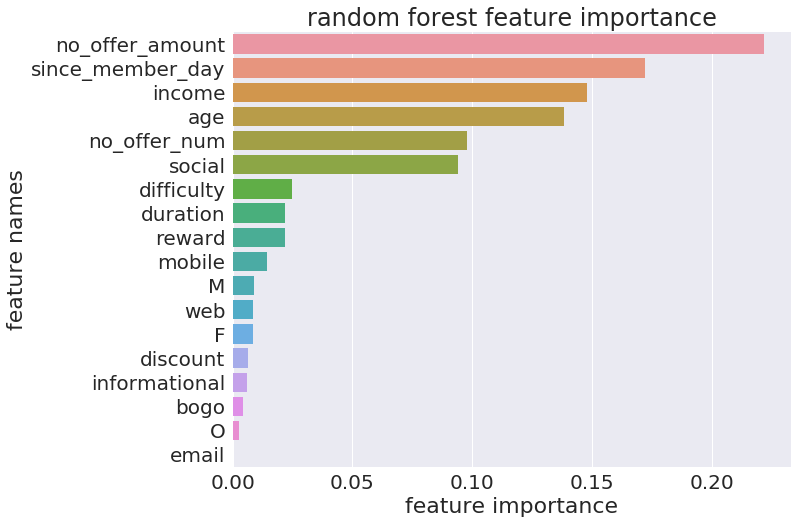

In [55]:
# plot the feature importance chart
clf.fit(X_train, y_train)
plot_feature_importance(clf.feature_importances_, X.columns)